# Machine Learning Model with Combined Time-Series and Tabular Data

## Introduction

This notebook presents the development of a machine learning model that integrates two types of patient data: time-series data and static tabular data. Time-series data, such as Mean Heart Rate (Mean_HR), Heart Rate Variability (SDNN_HRV), and the HF/LF ratio, provides a sequence of values over time, capturing trends and temporal dependencies that can be indicative of patient health status. On the other hand, tabular data, which includes demographic and static health information such as age, gender, and other vital signs, provides crucial context and background for each patient.

By combining these data types, we aim to create a robust model that leverages the temporal patterns in time-series data while simultaneously drawing insights from the static features in tabular data. This multi-input approach allows the model to better capture the nuances of patient health and potentially improve prediction accuracy for clinical outcomes.

The steps outlined in this notebook include data loading and preprocessing, model architecture design, and model training and evaluation. The use of a unique patient identification (patient ID) enables the seamless linking of tabular and time-series data, ensuring that each patient's information is properly aligned across datasets. The resulting model is designed to predict patient outcomes by integrating the complementary insights provided by both data types.


In [ ]:
#!pip install keras_tuner

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and time-series preprocessing
from sklearn.model_selection import train_test_split

# TensorFlow / Keras (for deep learning model)
import tensorflow as tf
from tensorflow.keras.layers import Input, Masking, LSTM, Masking, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner import Objective
from tensorflow.keras.models import load_model


# Metrics and evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, classification_report


import pickle
import os

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Der Befehl "nvidia-smi" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# 0. Set Flags for different notebook behavior

In [2]:
# If the model should be retrained or loaded
retrain_model = False

## 1. Load all needed data

In [3]:
# Loading the dataset that has been fully prepared for distance based prediction
with open('data/machine_learning_patient_data.pkl', 'rb') as f:
    machine_learning_patient_data = pickle.load(f)

machine_learning_patient_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc
0,284,-0.522787,False,True,True,False,False,True,False,False,False,True,False,-0.215362
1,286,1.525272,True,False,False,True,False,False,False,True,True,False,False,-1.023892
2,296,-0.842797,False,True,True,False,False,False,True,False,False,True,False,-0.215362
3,299,-1.034802,False,True,True,False,False,True,False,False,False,True,False,-0.215362
4,303,-0.650791,False,True,True,False,False,True,False,False,False,True,False,0.225655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,False,True,False,False,True,False,False,-1.023892
603,1017,-2.250837,False,True,True,False,False,False,False,True,True,False,False,2.283731
604,1018,0.117231,False,True,True,False,False,False,True,False,False,True,False,0.041898
605,1019,0.693248,False,True,True,False,False,False,True,False,False,True,False,-0.215362


In [4]:
# Load ecg data
ecg_data = pd.read_csv('data/ecg_data.csv')

ecg_data

,Patient_ID,Segment_1_Mean_HR,Segment_1_HRV_SDNN,Segment_1_LF_HF_Ratio,Segment_2_Mean_HR,Segment_2_HRV_SDNN,Segment_2_LF_HF_Ratio,Segment_3_Mean_HR,Segment_3_HRV_SDNN,Segment_3_LF_HF_Ratio,...,Segment_285_LF_HF_Ratio,Segment_286_Mean_HR,Segment_286_HRV_SDNN,Segment_286_LF_HF_Ratio,Segment_287_Mean_HR,Segment_287_HRV_SDNN,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_HF_Ratio
0,284,0.767585,-0.049949,-0.143019,0.767585,-0.049949,-0.143019,0.767585,-0.049949,-0.143019,...,-0.308781,0.113971,0.998257,-0.326269,0.180948,0.865033,-0.265086,0.268891,0.804852,-0.292048
1,286,-1.123594,1.956230,-0.447932,-1.123594,1.956230,-0.447932,-1.123594,1.956230,-0.447932,...,-0.334626,-0.750374,1.160116,-0.298228,-0.712291,1.175686,-0.121390,-0.286107,1.369312,-0.051627
2,296,0.861586,-0.868920,-0.260004,0.861586,-0.868920,-0.260004,0.861586,-0.868920,-0.260004,...,-0.321703,0.244215,0.112291,-0.348079,0.239714,0.111805,-0.366870,0.233466,0.107830,-0.369220
3,299,-0.766708,0.476145,-0.360076,-0.766708,0.476145,-0.360076,-0.766708,0.476145,-0.360076,...,-0.076170,-0.264920,0.589350,-0.020928,-0.430215,0.996954,-0.154320,-0.439618,0.779195,-0.173321
4,303,3.167009,0.656553,-0.236044,3.167009,0.656553,-0.236044,3.167009,0.656553,-0.236044,...,-0.402471,-1.117424,0.956514,-0.506981,-1.170663,0.320325,-0.459674,-1.207170,-0.148743,-0.505755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,-0.307854,1.310245,-0.503841,-0.307854,1.310245,-0.503841,-0.307854,1.310245,-0.503841,...,-0.379856,-0.537248,1.343272,-0.413510,-0.559500,1.303352,-0.390820,-0.569511,1.292340,-0.312825
603,1017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
604,1018,1.400102,-1.290823,-0.735462,1.400102,-1.290823,-0.735462,1.400102,-1.290823,-0.735462,...,-0.551083,1.309845,-1.163414,-0.591106,1.297497,-1.158470,-0.618339,1.308038,-1.117305,-0.553246
605,1019,-1.167409,0.107337,-0.168859,-1.167409,0.107337,-0.168859,-1.167409,0.107337,-0.168859,...,0.473049,-1.070063,0.230704,0.384116,-1.064885,-0.015861,0.405496,-1.077276,-0.088876,0.417342


In [5]:
# Loading the dataset that has the target value and original features and values
with open('data/patient_data.pkl', 'rb') as f:
    patient_data = pickle.load(f)

# Map 'Good' to 1 and 'Poor' to 0
patient_data['outcome'] = patient_data['outcome'].map({'Good': 1, 'Poor': 0}).astype(int)


patient_data

,Patient,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing
0,284,A,53.0,Male,NaN,True,True,33.0,1,1,1,0
1,286,F,85.0,Female,7.0,False,False,No TTM,1,1,0,0
2,296,A,48.0,Male,NaN,True,True,36.0,1,1,1,0
3,299,A,45.0,Male,NaN,True,True,33.0,1,1,1,0
4,303,D,51.0,Male,24.0,True,True,33.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,E,87.0,Male,7.0,True,False,33.0,0,5,0,0
603,1017,F,26.0,Male,52.0,True,False,No TTM,0,5,0,0
604,1018,E,63.0,Male,NaN,True,True,36.0,0,5,1,0
605,1019,A,72.0,Male,NaN,True,True,36.0,1,1,1,0


## 2. Combine the DataFrames

To prepare the data for analysis, we will combine the patient demographic data from `machine_learning_patient_data` with the ECG evaluations in `ecg_data`. Each patient’s information should be stored in a single row to ensure all relevant data is aligned correctly.

We’ll perform the combination by merging the two DataFrames on the `Patient` column from `machine_learning_patient_data` and the `Patient_ID` column from `ecg_data`, which uniquely identify each patient across the datasets.

This step enables us to work with a unified dataset, making it easier to analyze patient data holistically and develop machine learning models using both tabular and time-series data.

In [6]:
# Step 1: Merge machine_learning_patient_data and ecg_data on patient identifiers
combined_data = pd.merge(
    machine_learning_patient_data, ecg_data,
    left_on='Patient', right_on='Patient_ID',
    how='inner'
)

# Step 2: Merge the resulting combined_data with patient_data to add the 'outcome' column
combined_data = pd.merge(
    combined_data, patient_data[['Patient', 'outcome']],
    on='Patient',
    how='inner'
)
combined_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,...,Segment_286_Mean_HR,Segment_286_HRV_SDNN,Segment_286_LF_HF_Ratio,Segment_287_Mean_HR,Segment_287_HRV_SDNN,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_HF_Ratio,outcome
0,284,-0.522787,False,True,True,False,False,True,False,False,...,0.113971,0.998257,-0.326269,0.180948,0.865033,-0.265086,0.268891,0.804852,-0.292048,1
1,286,1.525272,True,False,False,True,False,False,False,True,...,-0.750374,1.160116,-0.298228,-0.712291,1.175686,-0.121390,-0.286107,1.369312,-0.051627,1
2,296,-0.842797,False,True,True,False,False,False,True,False,...,0.244215,0.112291,-0.348079,0.239714,0.111805,-0.366870,0.233466,0.107830,-0.369220,1
3,299,-1.034802,False,True,True,False,False,True,False,False,...,-0.264920,0.589350,-0.020928,-0.430215,0.996954,-0.154320,-0.439618,0.779195,-0.173321,1
4,303,-0.650791,False,True,True,False,False,True,False,False,...,-1.117424,0.956514,-0.506981,-1.170663,0.320325,-0.459674,-1.207170,-0.148743,-0.505755,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,False,True,False,False,...,-0.537248,1.343272,-0.413510,-0.559500,1.303352,-0.390820,-0.569511,1.292340,-0.312825,0
603,1017,-2.250837,False,True,True,False,False,False,False,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
604,1018,0.117231,False,True,True,False,False,False,True,False,...,1.309845,-1.163414,-0.591106,1.297497,-1.158470,-0.618339,1.308038,-1.117305,-0.553246,0
605,1019,0.693248,False,True,True,False,False,False,True,False,...,-1.070063,0.230704,0.384116,-1.064885,-0.015861,0.405496,-1.077276,-0.088876,0.417342,1


## 3. Convert the Time-Series Data into a 3D Array

To prepare the time-series data for model training, we will convert it into a 3D array format. This structure is ideal for deep learning models, as it retains both the temporal order and multivariate nature of each time step, allowing the model to capture complex sequential patterns.

### Array Structure

The 3D array will have the following dimensions:
- **Samples**: Each sample represents a unique patient.
- **Time Steps**: Each time step corresponds to a specific segment (e.g., Segment_1, Segment_2, etc.), capturing the sequential nature of the ECG data over time.
- **Features**: Each time step contains multiple features (e.g., Mean_HR, HRV_SDNN, LF_Power, HF_Power, LF_HF_Ratio), representing different physiological measurements at that moment in time.

This format ensures that our deep learning model can process the data effectively by learning from both the temporal sequence and the interrelationships between multiple features.

In [7]:
# Identify time-series columns for the selected features
selected_time_series_cols = [col for col in combined_data.columns if
                             any(feature in col for feature in ["Mean_HR", "HRV_SDNN", "LF_HF_Ratio"])]

# Reshape the time-series data into (samples, time steps, features)
X_time_series = combined_data[selected_time_series_cols].values.reshape(
    len(combined_data),  # samples (number of patients)
    -1,                  # time steps (number of segments per patient)
    3                    # features (3 values per time point: Mean_HR, HRV_SDNN, LF_HF_Ratio)
)

In [8]:
X_time_series.shape

(607, 288, 3)

In [9]:
# Identify tabular and time-series columns
tabular_cols = [
    'age', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_False', 'ohca_Unknown',
    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'shockable_rhythm_False',
    'shockable_rhythm_True', 'shockable_rhythm_Unknown', 'rosc'
]
time_series_cols = [col for col in combined_data.columns if 'Segment' in col]

# Separate the data
X_tabular = combined_data[tabular_cols].values  # Tabular data as 2D array
X_tabular


array([[-0.5227873191746347, False, True, ..., True, False,
        -0.21536175910764516],
       [1.5252716087919354, True, False, ..., False, False,
        -1.0238916807054788],
       [-0.8427965266694113, False, True, ..., True, False,
        -0.21536175910764516],
       ...,
       [0.11723109581491842, False, True, ..., True, False,
        0.04189776140075642],
       [0.6932476693055162, False, True, ..., True, False,
        -0.21536175910764516],
       [0.37323846181073966, False, True, ..., True, False,
        -0.21536175910764516]], dtype=object)

In [10]:
# Extract the outcome column as the target variable
y = combined_data['outcome'].values
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [11]:
# Split the data into training and validation sets
X_tabular_train, X_tabular_val, X_time_series_train, X_time_series_val, y_train, y_val = train_test_split(
    X_tabular, X_time_series, y, test_size=0.10, random_state=42
)

In [12]:
# Ensure tabular and time-series data are float32
X_tabular_train = X_tabular_train.astype('float32')
X_tabular_val = X_tabular_val.astype('float32')
X_time_series_train = X_time_series_train.astype('float32')
X_time_series_val = X_time_series_val.astype('float32')

In [14]:
def build_model(hp):
    # Define the input for tabular data
    input_tabular = Input(shape=(X_tabular.shape[1],), name="tabular_input")

    # Define the input for time-series data
    input_time_series = Input(shape=(X_time_series.shape[1], X_time_series.shape[2]), name="time_series_input")

    # Add a Masking layer for time-series data
    masked_time_series = Masking(mask_value=0)(input_time_series)

    # First LSTM layer with return_sequences=True to allow stacking
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=128, step=32)
    lstm_out = LSTM(lstm_units, use_cudnn=False, return_sequences=True, recurrent_activation="sigmoid")(masked_time_series)

    # Conditional second LSTM layer with cuDNN disabled and return_sequences=False
    if hp.Boolean("add_second_lstm_layer"):
        lstm_out = LSTM(lstm_units // 2, return_sequences=False, use_cudnn=False, recurrent_activation="sigmoid")(lstm_out)
        lstm_out = Dropout(0.2)(lstm_out)  # Dropout for regularization
    else:
        lstm_out = LSTM(lstm_units // 2, return_sequences=False, use_cudnn=False, recurrent_activation="sigmoid")(lstm_out)


    # Concatenate the LSTM output with the tabular input
    combined = Concatenate()([input_tabular, lstm_out])

    # Continue with your dense layers as before
    dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32)
    num_dense_layers = hp.Int("num_dense_layers", min_value=1, max_value=3)

    # Dynamically add dense layers with dropout if more than one layer
    dense_out = combined
    for i in range(num_dense_layers):
        dense_out = Dense(dense_units // (2 ** i), activation="relu")(dense_out)
        if num_dense_layers > 1:
            dense_out = Dropout(0.3)(dense_out)  # Apply dropout for multiple dense layers

    # Final output layer
    output = Dense(1, activation="sigmoid")(dense_out)

    # Compile the model
    model = Model(inputs=[input_tabular, input_time_series], outputs=output)
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy", AUC(name="roc_auc")])

    return model


In [15]:
# Only perform this if retrain_model flag is True
if retrain_model:
    # Define the tuner with the objective specified explicitly
    tuner = kt.RandomSearch(
        build_model,
        objective=Objective("val_roc_auc", direction="max"),
        max_trials=96,
        executions_per_trial=2,  # Average results over multiple runs
        directory="hyperparam_tuning",
        project_name="my_model_tuning"
    )

    # Early stopping for the tuning process
    early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

    # Start tuning
    tuner.search(
        [X_tabular_train, X_time_series_train], y_train,
        validation_data=([X_tabular_val, X_time_series_val], y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping]
    )

In [16]:
if retrain_model:
    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Rebuild the model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hps)

    # Print all the hyperparameters
    print("Best Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")

    # Save the model in SavedModel format
    best_model.save("models/neural_network.keras")

else:
    # Load the pre-saved model
    best_model = load_model("models/neural_network.keras")

c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
# Display the model architecture
best_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 288, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 288, 3)    │          0 │ time_series_inpu… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 288, 3)    │          0 │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 288)       │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 288, 128)  │     67,584 │ masking_2[0][0],  │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     49,408 │ lstm_4[0][0],     │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 77)        │          0 │ tabular_input[0]… │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,496 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        528 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        136 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8)         │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │          9 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 360,485 (1.38 MB)

 Trainable params: 120,161 (469.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 240,324 (938.77 KB)

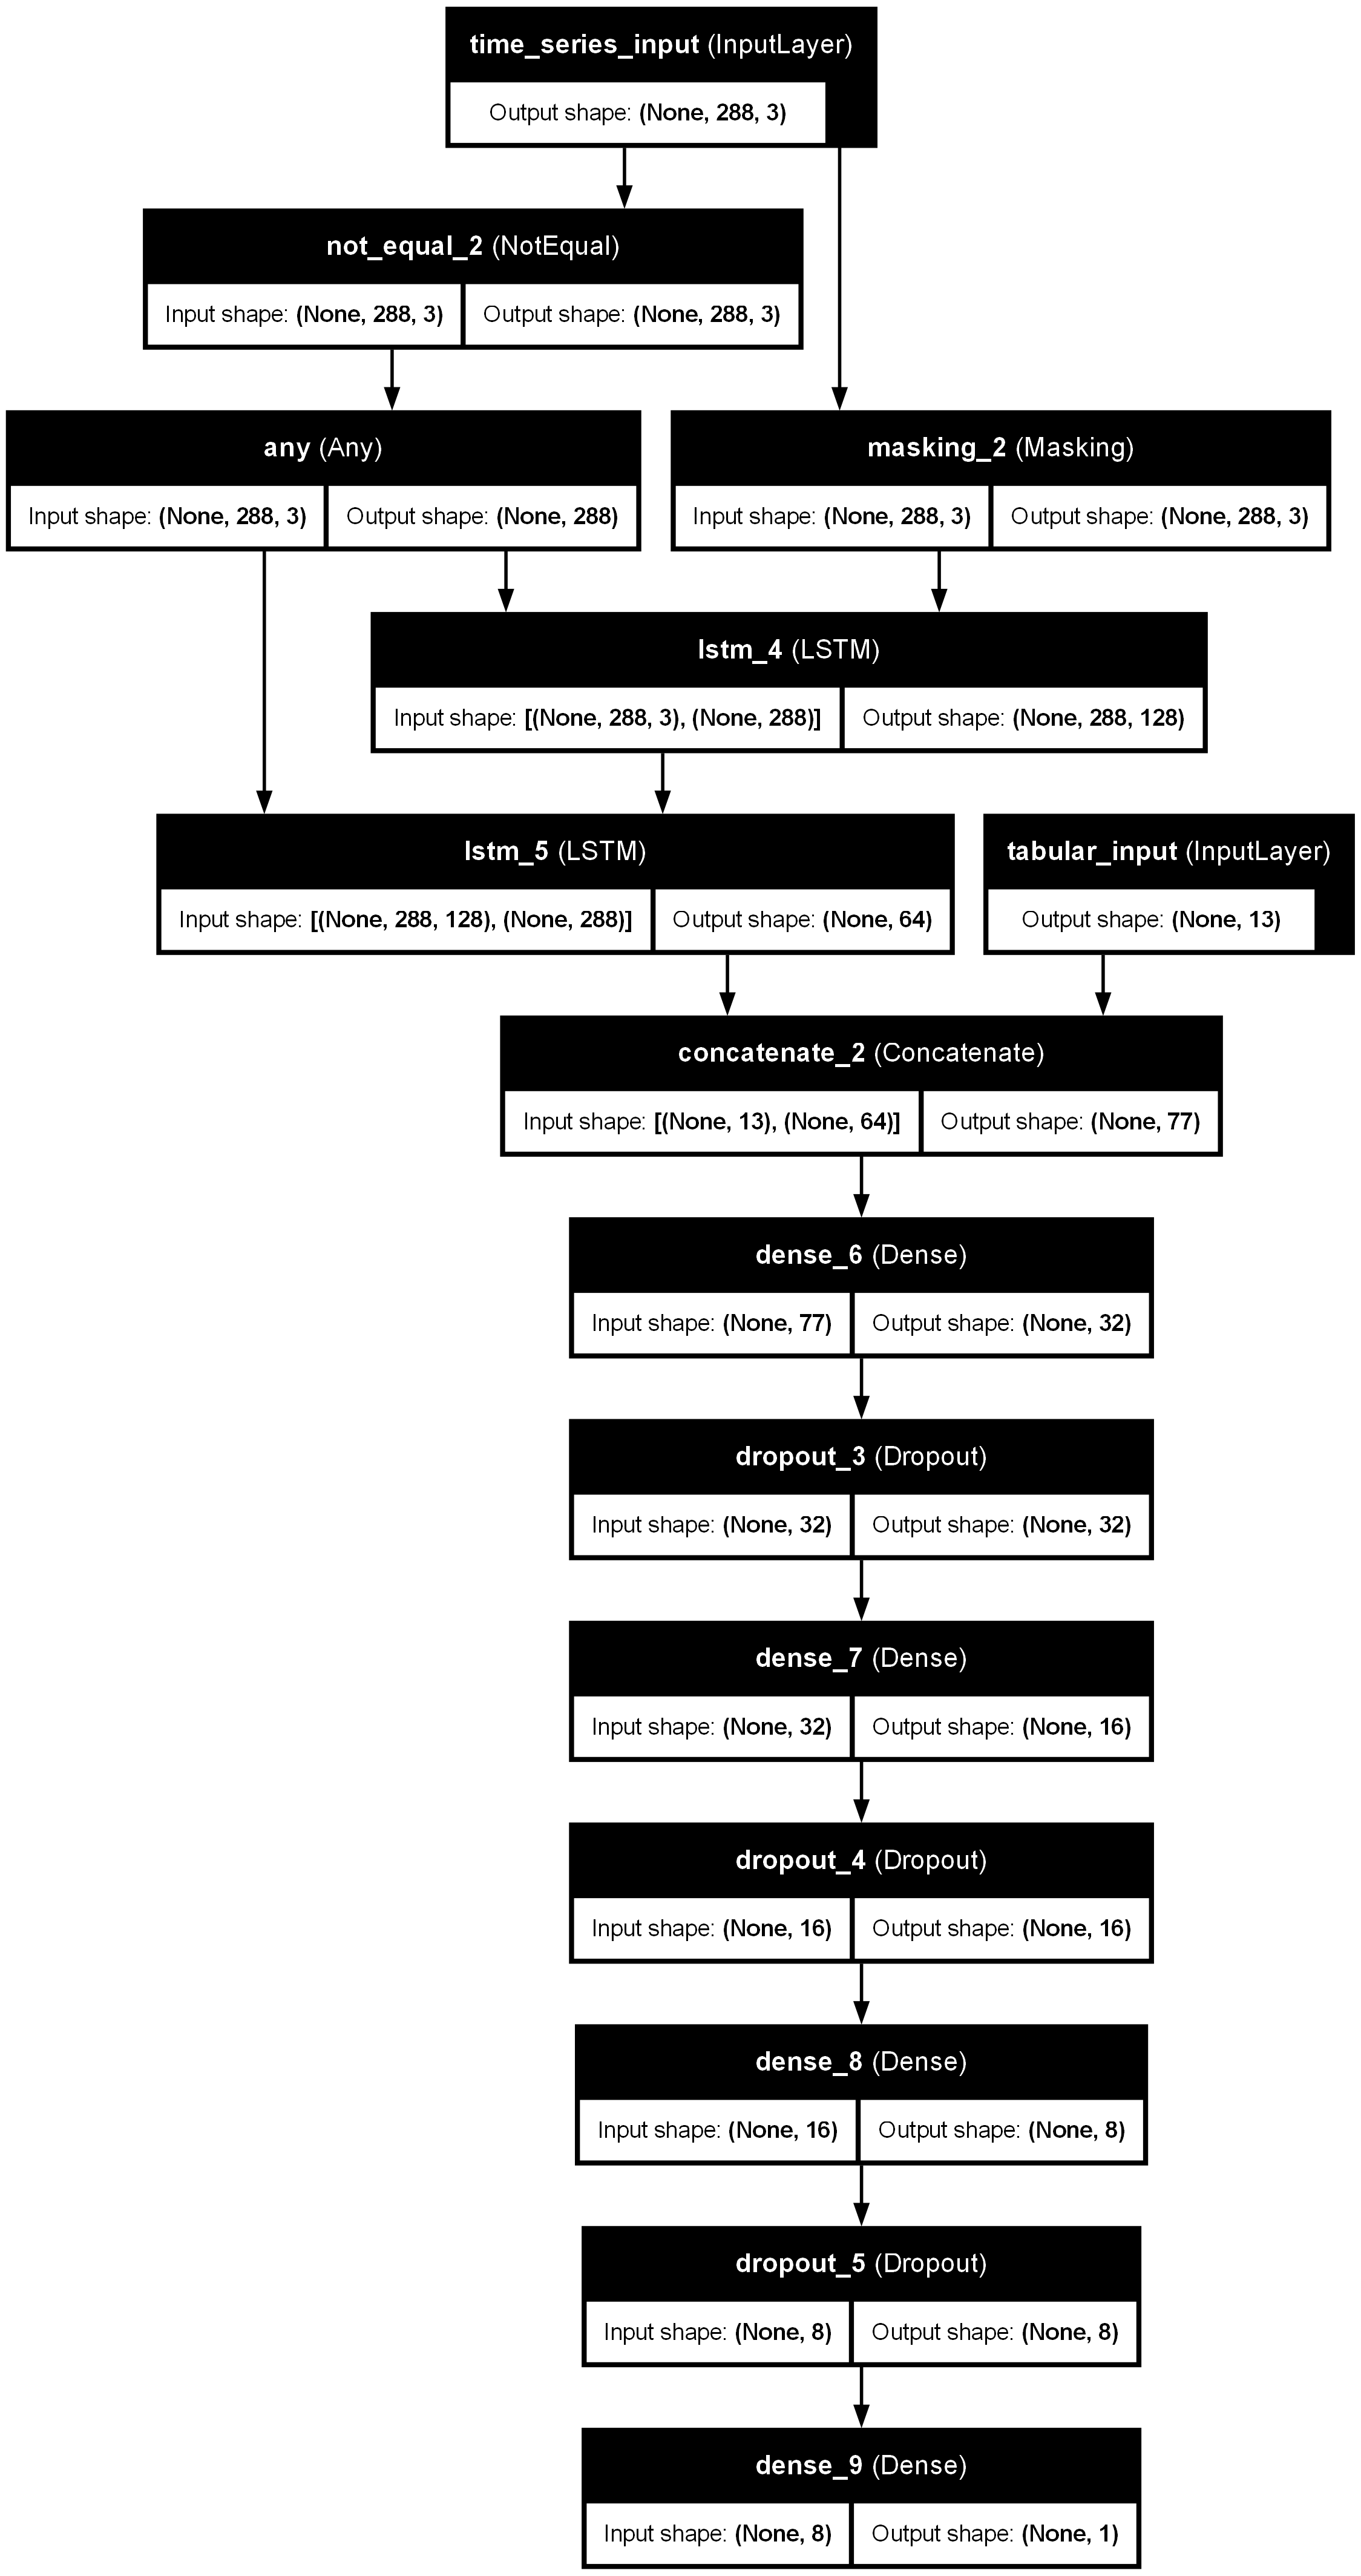

In [18]:
# Generate a plot of the model
plot_model(best_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [19]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Retrain the best model on the training data
history = best_model.fit(
    [X_tabular_train, X_time_series_train], y_train,
    validation_data=([X_tabular_val, X_time_series_val], y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
loss, accuracy, roc_auc = best_model.evaluate([X_tabular_val, X_time_series_val], y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation ROC AUC: {roc_auc}")


Epoch 1/50


c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['tabular_input', 'time_series_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 672ms/step - accuracy: 0.3753 - loss: 0.7949 - roc_auc: 0.4629 - val_accuracy: 0.4426 - val_loss: 0.7030 - val_roc_auc: 0.7413
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.4782 - loss: 0.7000 - roc_auc: 0.5945 - val_accuracy: 0.7213 - val_loss: 0.6790 - val_roc_auc: 0.7587
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - accuracy: 0.5780 - loss: 0.6851 - roc_auc: 0.6062 - val_accuracy: 0.7541 - val_loss: 0.6654 - val_roc_auc: 0.7908
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - accuracy: 0.5918 - loss: 0.6707 - roc_auc: 0.6093 - val_accuracy: 0.7377 - val_loss: 0.6485 - val_roc_auc: 0.7767
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - accuracy: 0.6436 - loss: 0.6714 - roc_auc: 0.6354 - val_accuracy: 0.7869 - val_loss: 0.6482 - val_roc_auc: 0.8703
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.5785 - loss: 0.6699 - roc_auc: 0.6015 - val_accuracy: 0.7705 - val_loss: 0.6298 - val_roc_auc: 0.8422
Ep

In [20]:
# Evaluate on the validation set with additional metrics
loss, accuracy, roc_auc = best_model.evaluate([X_tabular_val, X_time_series_val], y_val)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation ROC AUC: {roc_auc}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8058 - loss: 0.4178 - roc_auc: 0.9011
Validation Loss: 0.42821183800697327
Validation Accuracy: 0.7868852615356445
Validation ROC AUC: 0.895053505897522


In [21]:
# Generate predictions on the validation set
y_pred_prob = best_model.predict([X_tabular_val, X_time_series_val]).flatten()

# Convert probabilities to binary labels (using 0.5 threshold for binary classification)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print the classification report
print(classification_report(y_val, y_pred, target_names=["Class 0", "Class 1"]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
              precision    recall  f1-score   support

     Class 0       0.84      0.86      0.85        44
     Class 1       0.62      0.59      0.61        17

    accuracy                           0.79        61
   macro avg       0.73      0.73      0.73        61
weighted avg       0.78      0.79      0.78        61



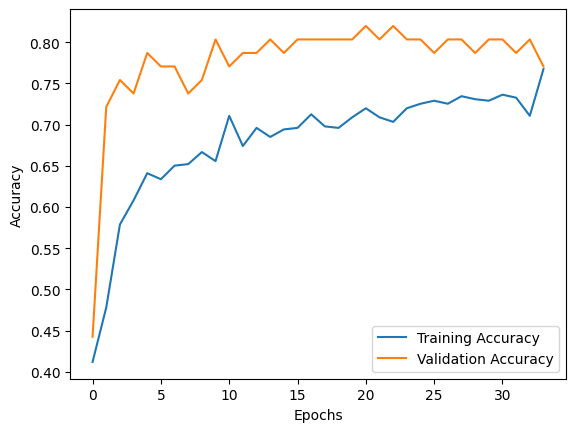

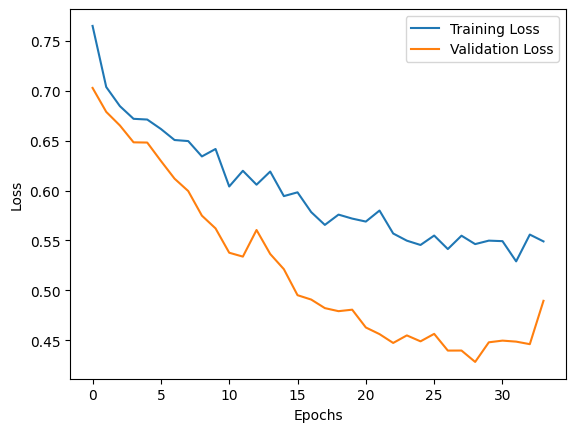

In [22]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Predictions on the validation set
predictions = best_model.predict([X_tabular_val, X_time_series_val])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


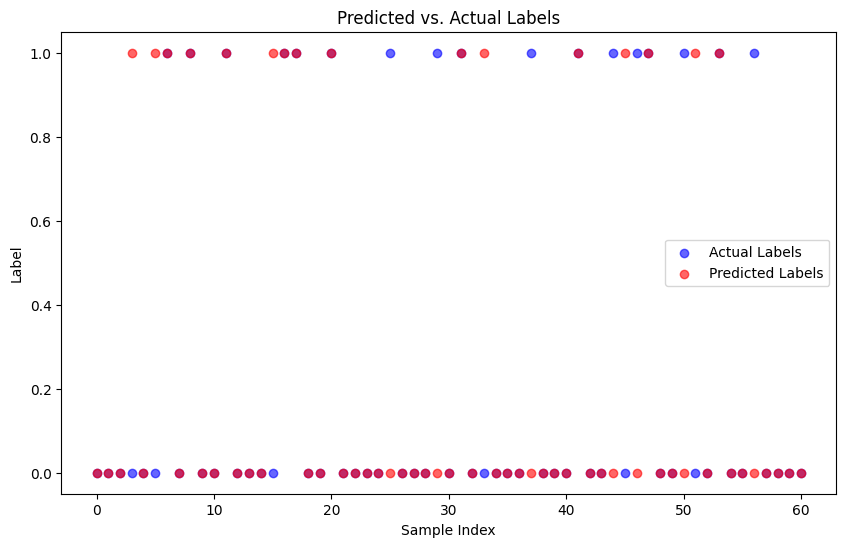

In [24]:
# Generate predictions on the validation set
predictions = best_model.predict([X_tabular_val, X_time_series_val])

# If your predictions are probabilities, convert them to binary labels
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Threshold at 0.5 for binary classification

# Flatten y_val if it’s not already
actual_labels = y_val.flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_labels)), actual_labels, color="blue", label="Actual Labels", alpha=0.6)
plt.scatter(range(len(predicted_labels)), predicted_labels, color="red", label="Predicted Labels", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.legend()
plt.title("Predicted vs. Actual Labels")
plt.show()

In [25]:
# Load roc_data dictionary from the file
with open("data/roc_data.pkl", "rb") as f:
    roc_data = pickle.load(f)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


C:\Users\kentf\AppData\Local\Temp\ipykernel_10376\3572652186.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", num_models)  # 'tab10' is a colormap with 10 distinct colors


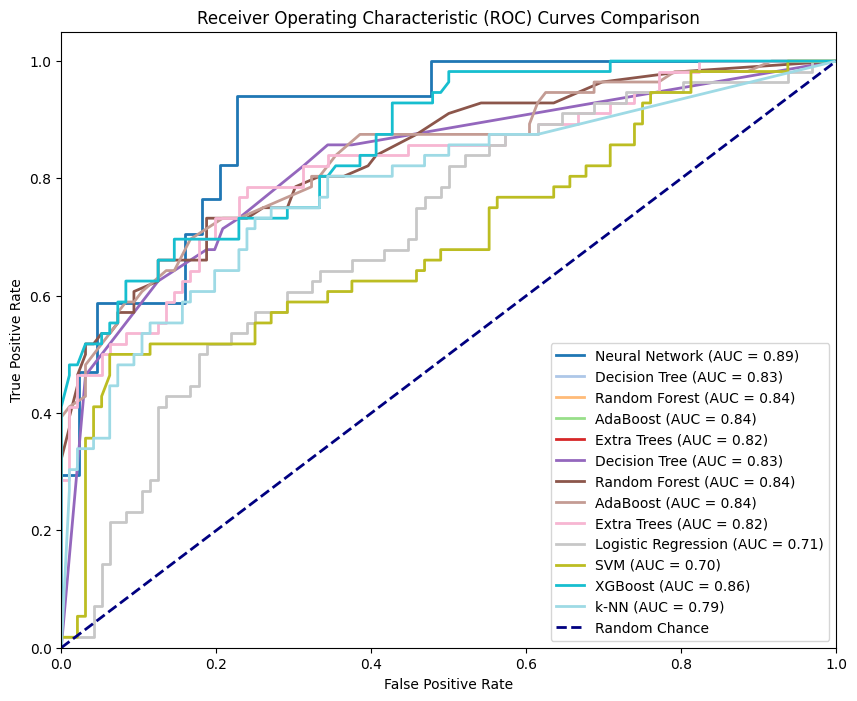

In [26]:
# Neural network predictions and ROC
y_pred_prob = best_model.predict([X_tabular_val, X_time_series_val]).flatten()
fpr_nn, tpr_nn, _ = roc_curve(y_val, y_pred_prob)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Number of models including the neural network
num_models = len(roc_data['Model Name']) + 1  # +1 for the neural network

# Generate a colormap
colors = plt.cm.get_cmap("tab20", num_models)  # 'tab10' is a colormap with 10 distinct colors

# Plot the neural network ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_nn, tpr_nn, color=colors(0), lw=2, label=f"Neural Network (AUC = {roc_auc_nn:.2f})")

# Plot ROC curves for each other model from roc_data
for i in range(len(roc_data['Model Name'])):
    model_name = roc_data['Model Name'][i]
    fpr = roc_data['FPR'][i]
    tpr = roc_data['TPR'][i]
    model_auc = roc_data['AUC'][i]
    plt.plot(fpr, tpr, color=colors(i + 1), lw=2, label=f"{model_name} (AUC = {model_auc:.2f})")

# Plot the random chance line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Chance")

# Set labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves Comparison")
plt.legend(loc="lower right")
plt.show()


In [27]:
# Assuming y_val are true labels and y_pred_prob are predicted probabilities for the Neural Network
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Calculate the Euclidean distance to the upper-left corner (0, 1) for each point on the ROC curve
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Find the index of the minimum distance
optimal_index = distances.argmin()
optimal_threshold = thresholds[optimal_index]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"TPR (Sensitivity) at Optimal Threshold: {tpr[optimal_index]}")
print(f"FPR at Optimal Threshold: {fpr[optimal_index]}")


Optimal Threshold: 0.34601226449012756
TPR (Sensitivity) at Optimal Threshold: 0.9411764705882353
FPR at Optimal Threshold: 0.22727272727272727


In [34]:
# Load the previous model results
results_df = pd.read_csv("data/model_results.csv")

# Neural network predictions on the validation set
y_pred = (best_model.predict([X_tabular_val, X_time_series_val]) > optimal_threshold).astype("int32")

# Calculate metrics for the neural network
nn_metrics = {
    "Model Name": "Neural Network",
    "Accuracy": accuracy_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "F1 Score": f1_score(y_val, y_pred),
    "AUC": roc_auc_score(y_val, best_model.predict([X_tabular_val, X_time_series_val]))
}

# Convert the neural network metrics to a DataFrame
nn_metrics_df = pd.DataFrame([nn_metrics])

# Concatenate the neural network metrics with the existing results DataFrame
results_df = pd.concat([results_df, nn_metrics_df], ignore_index=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


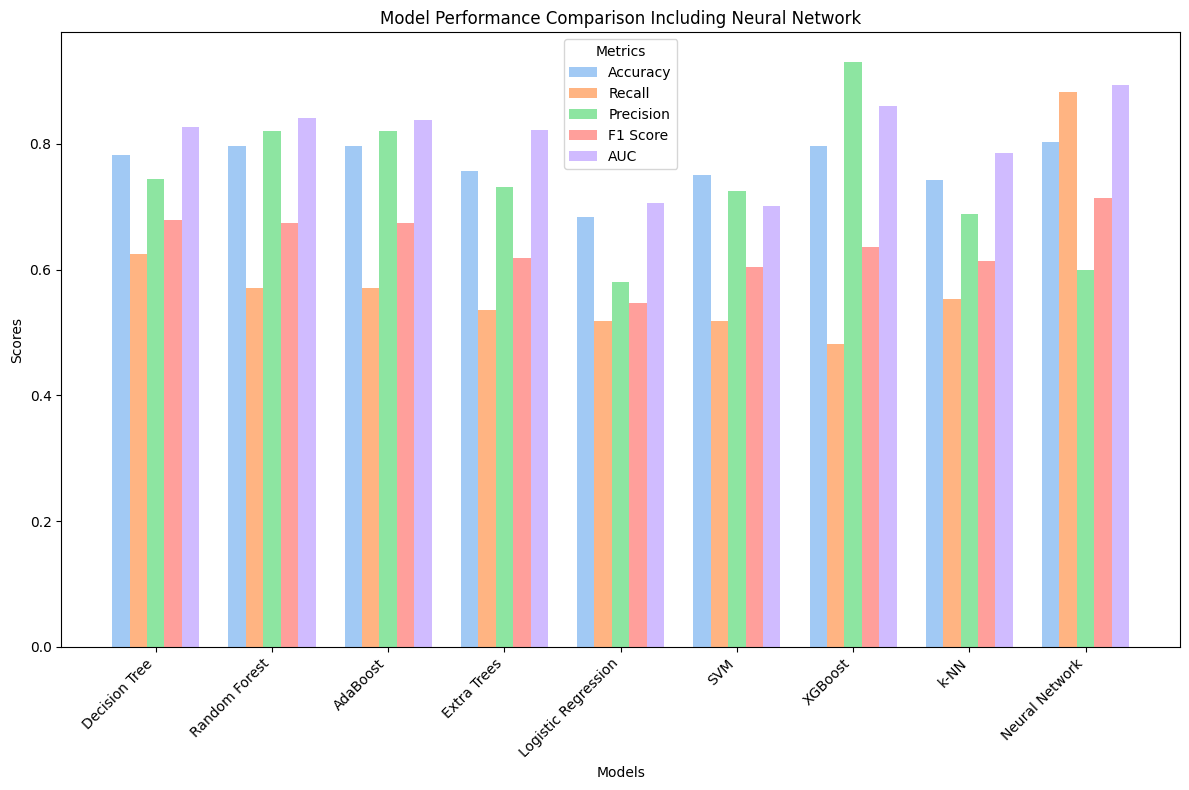

In [35]:
# Define the chart metrics and models
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
models = results_df['Model Name']
n_metrics = len(metrics)
n_models = len(models)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define the bar width and positions for each group
bar_width = 0.15
index = np.arange(n_models)

# Use Seaborn's color palette for pastel colors
colors = sns.color_palette("pastel", n_colors=n_metrics)

# Plot each metric for each model side by side with pastel colors
for i, (metric, color) in enumerate(zip(metrics, colors)):
    metric_values = results_df[metric]
    ax.bar(index + i * bar_width, metric_values, bar_width, label=metric, color=color)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison Including Neural Network')
ax.set_xticks(index + bar_width * (n_metrics - 1) / 2)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(title="Metrics")

plt.tight_layout()
plt.show()


In [36]:
# Round values in the results DataFrame to 2 decimal places
results_df_rounded = results_df.round(2)

# Display the rounded DataFrame
results_df_rounded


,Model Name,Model Instance,Accuracy,Recall,Precision,F1 Score,AUC,Training Time (s),Prediction Time (s)
0,Decision Tree,"DecisionTreeClassifier(min_samples_leaf=4, ran...",0.78,0.62,0.74,0.68,0.83,3.78,0.00
1,Random Forest,"RandomForestClassifier(n_estimators=50, random...",0.80,0.57,0.82,0.67,0.84,9.63,0.00
2,AdaBoost,"AdaBoostClassifier(algorithm='SAMME',\n ...",0.80,0.57,0.82,0.67,0.84,1.69,0.02
3,Extra Trees,"ExtraTreesClassifier(max_depth=20, min_samples...",0.76,0.54,0.73,0.62,0.82,6.81,0.01
4,Logistic Regression,"LogisticRegression(C=1, max_iter=200, solver='...",0.68,0.52,0.58,0.55,0.71,0.31,0.00
5,SVM,"SVC(C=100, probability=True)",0.75,0.52,0.72,0.60,0.70,0.99,0.01
6,XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.80,0.48,0.93,0.64,0.86,2.28,0.01
7,k-NN,"KNeighborsClassifier(metric='manhattan', n_nei...",0.74,0.55,0.69,0.61,0.79,0.15,0.00
8,Neural Network,NaN,0.80,0.88,0.60,0.71,0.89,NaN,NaN


### SHAP Interpretation

As our model is reaching a good performance on the classification tasks, we try to find out what values drive the prediction the most. For this, we are using SHAP interpreatiation and visualization.

In [37]:
import shap
import numpy as np

# Shape of tabular and time-series inputs
tabular_shape = X_tabular_val.shape[1]
time_series_shape = X_time_series_val.shape[1:]

# Create a custom predict function that provides both inputs to the model
def model_predict(data, tabular_shape, time_series_shape):
    # Split data into tabular and time-series components for SHAP
    X_tabular = data[:, :tabular_shape]
    X_time_series = np.reshape(data[:, tabular_shape:], (-1, *time_series_shape))

    # Use the model's predict function with both inputs
    return best_model.predict([X_tabular, X_time_series])

# Concatenate a subset of `X_tabular_val` and `X_time_series_val` for SHAP input
X_tabular_subset = X_tabular_val[:3]
X_time_series_subset = X_time_series_val[:3]
X_shap_input = np.hstack([X_tabular_subset, X_time_series_subset.reshape(X_time_series_subset.shape[0], -1)])

# Initialize KernelExplainer with the custom predict function
explainer = shap.KernelExplainer(lambda data: model_predict(data, tabular_shape, time_series_shape), X_shap_input)

# Calculate SHAP values for a subset
shap_values = explainer.shap_values(X_shap_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step


In [38]:
# 1. Load tabular feature names (if known and based on the columns provided)
tabular_feature_names = [
    'age', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_Unknown',
    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'shockable_rhythm_False',
    'shockable_rhythm_True', 'shockable_rhythm_Unknown', 'rosc'
]

# 2. Generate time-series feature names with specific variable names
time_series_feature_names = [
    f"time_step_{t}_Mean_HR" for t in range(X_time_series_val.shape[1])
] + [
    f"time_step_{t}_HRV_SDNN" for t in range(X_time_series_val.shape[1])
] + [
    f"time_step_{t}_LF_HF_RATIO" for t in range(X_time_series_val.shape[1])
]

# 3. Combine tabular and time-series feature names
feature_names = tabular_feature_names + time_series_feature_names

# Check if the length of feature_names matches the number of features in X_shap_input
assert len(feature_names) == X_shap_input.shape[1], "Mismatch in the number of features and feature names."


AssertionError: Mismatch in the number of features and feature names.

Shape of shap_values: (3, 877, 1)
Length of feature_names: 876


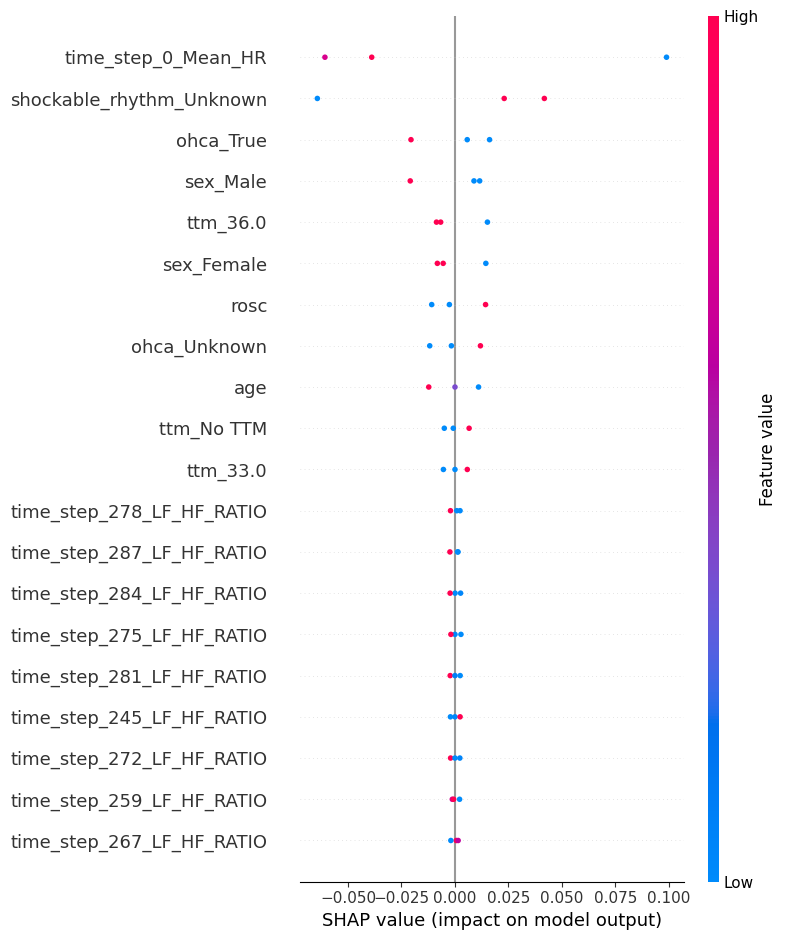

In [39]:
# Check the shape of SHAP values
print("Shape of shap_values:", np.array(shap_values).shape)

# Check if feature_names has the correct length
print("Length of feature_names:", len(feature_names))  # This should print 876

# Select the SHAP values for all instances to match the number of rows in X_shap_input
shap_values_aligned = shap_values[:, :, 0]  # Remove the last dimension, shape becomes (2, 876)

# Check that shap_values_aligned and X_shap_input have the same number of rows
assert shap_values_aligned.shape[0] == X_shap_input.shape[0], "Number of rows in shap_values and X_shap_input must match."

# Generate the summary plot
shap.summary_plot(shap_values_aligned, X_shap_input, feature_names=feature_names)


